<a href="https://colab.research.google.com/github/shivanijoshi05/speech_emotion_recognition/blob/main/audio_preprocessing_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading Libraries

In [1]:
import os
import librosa
import librosa.display
import pandas as pd
import numpy as np
from tqdm import tqdm
import IPython.display as ipd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
import glob
drive.mount('/content/drive')

Mounted at /content/drive


Loading Dataset

In [17]:
path = glob.glob('/content/drive/MyDrive/speech_emotion_recognition/*.*')
audio_df = pd.read_csv(path[-1])
audio_df.head()


,actor,gender,emotion,path
0,1,male,neutral,data/Actor_01/03-01-01-01-01-01-01.wav
1,1,male,neutral,data/Actor_01/03-01-01-01-01-02-01.wav
2,1,male,neutral,data/Actor_01/03-01-01-01-02-01-01.wav
3,1,male,neutral,data/Actor_01/03-01-01-01-02-02-01.wav
4,1,male,calm,data/Actor_01/03-01-02-01-01-01-01.wav


# Data Augmentation

In [18]:
# Noise
# rate of noise = 0.035, Noise increases as rate increases
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size = data.shape[0])
    return data

# Stretch
# rate of stretching audio = 0.8, Audio is streched more as rate decreases
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

# Shift
# shifts the initial part of audio at the end in left to right direction
def shift(data):
    shift_range = int(np.random.uniform(low = -5, high = 5)*1000)
    return np.roll(data, shift_range)

# Pitch
# pitch_factor = 0.7 --> adjusts the pitch of the audio
# negative values for greater pitch, positive(higher) values for lower pitch
def pitch(data, sampling_rate, pitch_factor = 0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


Normal Audio

In [22]:
p = np.array(audio_df['path'])[1500]
path = glob.glob('/content/drive/MyDrive/speech_emotion_recognition/'+p)
data, sample_rate = librosa.load(path[0])

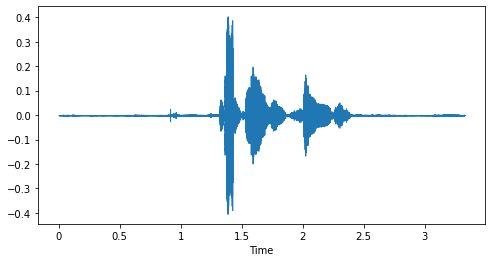

In [24]:
plt.figure(figsize=(8,4))
librosa.display.waveshow(y=data, sr=sample_rate)
ipd.Audio(path[0])

Audio with noise

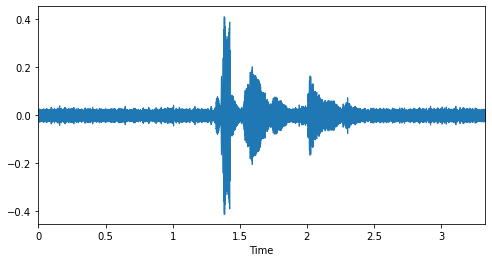

In [25]:
x = noise(data)
plt.figure(figsize=(8,4))
librosa.display.waveplot(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

Audio with stretch 

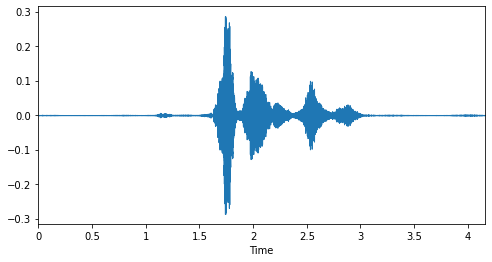

In [26]:
x = stretch(data)
plt.figure(figsize=(8, 4))
librosa.display.waveplot(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

Audio with shift

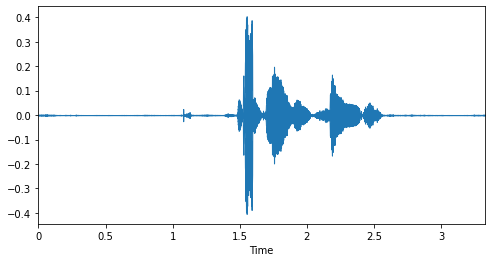

In [27]:
x = shift(data)
plt.figure(figsize=(8,4))
librosa.display.waveplot(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

Audio with pitch

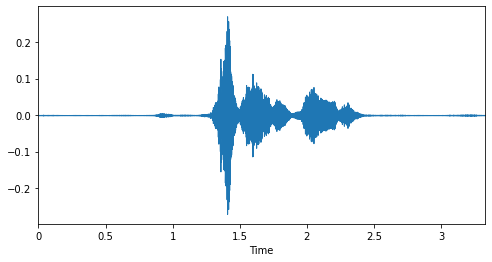

In [28]:
x = pitch(data, sample_rate)
plt.figure(figsize=(8, 4))
librosa.display.waveplot(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

# Feature Extraction

In [29]:
def feature_extraction(data):
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    return mfcc

# duration = 2.5, 
# offset = 0.6 --> considers audio of 2.5 duration starting from 0.6 sec
def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # normal data
    res1 = feature_extraction(data)
    result = np.array(res1)
    
    #data with noise
    noise_data = noise(data)
    res2 = feature_extraction(noise_data)
    result = np.vstack((result, res2))
    
    #data with stretch and pitch
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = feature_extraction(data_stretch_pitch)
    result = np.vstack((result, res3))
    
    return result

In [35]:
X, Y = [], []
for path, emotion in zip(audio_df['path'], audio_df['emotion']):
    p = glob.glob('/content/drive/MyDrive/speech_emotion_recognition/'+path)
    feature = get_features(p[0])
    for element in feature:
        X.append(element)
        Y.append(emotion)

In [42]:
Features = pd.DataFrame(X)
Features['labels'] = Y
path_save = glob.glob('/content/drive/MyDrive/speech_emotion_recognition/')
Features.to_csv(path_save[0]+'features.csv', index=False)

In [39]:
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-655.344543,86.649872,-12.361262,28.343275,-0.276913,9.111377,-10.830961,-0.023427,-17.030333,-3.272646,...,-5.887830,4.827703,-7.893806,3.420066,-1.663579,-3.320956,-4.437192,-0.790467,-2.032093,neutral
1,-597.755470,68.313810,-5.464898,20.184578,3.788270,3.487281,-7.885428,-4.084610,-14.670673,-5.026546,...,-4.231448,2.109232,-5.899222,0.484595,-1.115013,-4.200195,-4.516998,-1.035014,-2.638597,neutral
2,-724.306396,84.484604,-14.169168,31.050007,-3.062018,9.604833,-14.446255,-0.219572,-20.590328,2.435988,...,-4.019654,3.011943,-8.108849,3.908970,-5.971782,-3.685823,-5.657763,2.423672,-4.886151,neutral
3,-645.409851,87.810638,-17.773392,33.468960,-0.936478,8.191231,-9.919904,-3.311972,-18.590483,-2.199426,...,-6.660094,3.893641,-8.572474,2.928271,-3.344517,-3.604978,-4.101902,-1.308776,-0.581940,neutral
4,-404.925306,23.164804,9.385671,8.897342,4.922053,-0.220186,-2.471936,-5.645275,-7.439860,-4.069184,...,-1.902841,-1.711366,-1.941230,-0.232068,-0.532318,-3.133515,-2.275211,-0.308963,-1.582655,neutral
